## Paper summary 1: 
# Language-agnostic BERT Sentence Embedding

##### ACL 2022  ·  Fangxiaoyu Feng, Yinfei Yang, Daniel Cer, Naveen Arivazhagan, Wei Wang

[papers with code link](https://paperswithcode.com/paper/language-agnostic-bert-sentence-embedding)

[arxiv link](https://arxiv.org/abs/2007.01852)

Original paper Jul 2020, version 2 (the one we are looking at) Mar 2022, presented at ACL 2022 (Association for Computational Linguistics)

## Summary

This paper introduces novel sentence embedding model based on BERT (Bidirectional Encoder Representations from Transformers not 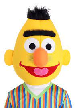) outperforming state-of the-art models on many cross-lingual and multilingual tasks, while still retaining competitive results in on monolingual tasks. LaBSE combines transfer learning from LLMs trained on masked language modeling (MLM) and translation language modeling (TLM), and dual encoder architecture with translation ranking task improved with additive margin softmax.

The tree main contributions of the paper:

+ A novel combination of pre-training and dualencoder finetuning boosting model's performance

+ A publicly released multilingual sentence embedding model [here](https://www.kaggle.com/models/google/labse/frameworks/tensorFlow2/variations/labse/versions/2?tfhub-redirect=true)

+ Thorough experiments and ablation studies to understand the impact of pre-training, negative sampling strategies, vocabulary choice, data quality, and data quantity

Text embeddings are useful for clustering, retrieval, text representations for downstream tasks. Existing cross-lingual sentence embedding is trained on translation pairs, in this work encoders from pre-trained LLMs are used to build a __dual encoder model__.

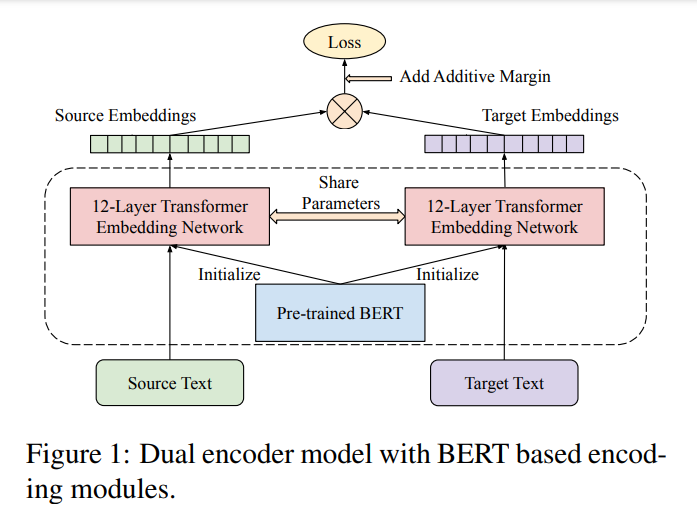


The model for __cross-lingual embeddings__ consist of two separate embedding models - source and target. The task is translation ranking task in batch negative sampling - which is to say rank source and target similarity above all other pairs in the batch, effectively maximizing the source-target similarity, while minimizing either the source's similarity with the other targets in the batch or minimizing the target's similarity with the other sources. This is the loss of the ranking task:

$$ \mathcal{L} = 
- \dfrac{1}{N} \sum^{N}_{i=1} log 
\dfrac{e^{ \phi (x_i, y_i)}}{e^{ \phi (x_i, y_i)} 
+ \sum^{N}_{n=1, n \neq i } e^{ \phi (x_i, y_n)} } $$

where
$ \phi (x, y) $ is embedding space similarity, usually
$ \phi (x, y) = x y^T$

Since the loss is different weather the softmax is applied over the source or the target sentences, to achieve symmetry combined loss is used:

$$ \bar{\mathcal{L}} = \mathcal{L} + \mathcal{L}'$$

where
$ \bar{\mathcal{L}}$ is total loss; $\mathcal{L}$ is source-to-target loss and $ \mathcal{L}'$ is target-to-source loss



The article states that __additive margin softmax__ greatly influences the performance of the model. This means extending the scoring function $\phi$ with a margin $m$, leading to greater distance between the positive pair and nearby negative examples.

$$ \phi '(x_i, y_i) = 
    \left\{ 
  \begin{array}{ c l }
    \phi (x_i, y_i) - m & \quad \textrm{if } i = j \\
    \phi (x_i, y_i)  & \quad \textrm{if } i \neq j
  \end{array}
\right.
$$

Simply put that is if it is a positive pair, make it look like the items inside are even more similar than they really are.
With the improved similarity function the loss looks like this:

$$ \mathcal{L} = 
- \dfrac{1}{N} \sum^{N}_{i=1} log 
\dfrac{e^{ \phi (x_i, y_i) - m}}{e^{ \phi (x_i, y_i) - m} 
+ \sum^{N}_{n=1, n \neq i } e^{ \phi (x_i, y_n)} } $$

Of course, for again using the bidirectional loss that is sum of source-to-target loss and target-to-source loss.



__Pre-training on MLM and TLM__ was combined and compared to randomly initialized dual encoder, showing that random model needed vastly greater training set to achieve similar the performance. Existing multilingual LLMs, even if they have good natural language processing capabilities, their encoder handles single sentence embeddings poorly - their performance on bitext
retrieval tasks is very weak (bitext as pairs of same text in different language).

The __corpus__ consists of _monolingual data_ from CommonCrawl and Wikipedia and _Bilingual Translation Pairs_ from web pages using a bitext mining system, subset of which is annotated from humans with GOOD / BAD labels for the translation quallity. 

__Configuration__ of the model:

+ transformer encoder - BERT Base model, with 12 transformer blocks, 12 attention heads and 768 per-position hidden units; shared parameters for all languages
+ two versions of the model, one using the public BERT multilingual cased vocabulary and a second with custom vocabulary from training data
+ word-piece tokenizer for the custom vocabulary
+ AdamW optimizer with linear weight decay
+ trained on 32 connected TPUs with local batch size 128
+ hyperparameters tuned on a held-out development set




Cross-lingual embedding models trained with inbatch negative samples benefit from large training batch sizes. BERT is a big model, which does not allow  big batch size on each core, no matter how many cores are used. Solution to this problem is __Cross-Accelerator Negative Sampling__ - strategy where each core encodes its input separately and then the already encoded sentences are used as negative examples in all other cores. This way the training is as effective as with it's global batch size (cores X local batch), keeping the  ressourse usage by each core almost the same - the computationally expensive work (the encoding itself) distributed and the scoring function efficiently computing the pairwise scores with simple dot-product.

Model is evaluated on three benchmarks for __Bitext Retrieval__ - United Nations (UN), Tatoeba, and BUCC with retrievel task - pick the correct English translation for each non-English sentence from a vast pool of candidates and on __downstream classification__ several tasks from the SentEval benchmark - movie review, sentiment analysis, questiontype, product reviews, subjectivity/objectivity, opinion polarity and paraphrasing detection. SentEval is English only, but it is used as benchmark in order to directly compare LaBSE to prior work on sentence embedding models. 






__Results__ point to the combination of customized vocabulary + additive margin softmax + pretraining as the best performing model. Overall good results on bitext retrieval, with even high Tatoeba accuracy for over 30 languages, that were not included in the training data. On pairwise English semantic similarity performs worse than existing English-only sentence embedding models. 

Two NMT (neural machine translation) model was trained with parallel text from CommonCrawl mined with LaBSE, an english - german and an english - chinese, both showing the state-of-the-art effectiveness of the mined data.

__Conclusion__

LaBSE model supports multiple languages, has state-of-the-art performance on variety of multilingual tasks. Most important factor for training was additive margin softmax, followed by the quality of the train data, the use pre-trained language models allows huge reduction in the quantity of train data.

Playing around with the code provided (in kaggle models and papers with code) in another notebook.